# Houston Heat Kernel Signature + Persistence Based Clustering

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from heat_kernel_func import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load city data file

In [2]:
luF1 = pd.read_csv('../houston/data/luF1_utm.csv')
print('Number of buildings:', len(luF1.index))

Number of buildings: 23581


In [3]:
m = Basemap(
        projection='merc',
        llcrnrlon=min(luF1['lon']),
        llcrnrlat=min(luF1['lat']),
        urcrnrlon=max(luF1['lon']),
        urcrnrlat=max(luF1['lat']),
        lat_ts=0,
        resolution='h',
        suppress_ticks=True)

## Finding $k$

In [4]:
def k_neighbors(points, weighted=True, k=3):
    '''
    weights are distance
    returns a weighted edgelist
    '''
    num_points = points.shape[0]
    
    # expanded out form of distance formula
    squared = (points ** 2).sum(axis=1, keepdims=True)
    mixed = points @ points.T
    dists = np.sqrt(squared + squared.T - (2 * mixed))

    closest_idx = np.argsort(dists, axis=1)[:, 1:(k + 1)]
    
    edge_list = []
    for i in range(num_points): # this can probably be parallelized
        cdists = dists[i, closest_idx[i]]
        if weighted:
            edge_list.extend([(i, j, cdists[k]) 
                              for k, j in enumerate(closest_idx[i])])
        else:
            edge_list.extend([(i, j, 1) 
                              for k, j in enumerate(closest_idx[i])])

    
    del dists
    del closest_idx
    
    return edge_list

weighted_edge_list = k_neighbors(luF1[['utm15_x', 'utm15_y']].values, k=12)
weighted_G = nx.Graph()
weighted_G.add_weighted_edges_from(weighted_edge_list)
components = nx.number_connected_components(weighted_G)
print('Number of connected components:', components)

/home/ubuntu/anaconda3/envs/mainEnv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


Number of connected components: 1


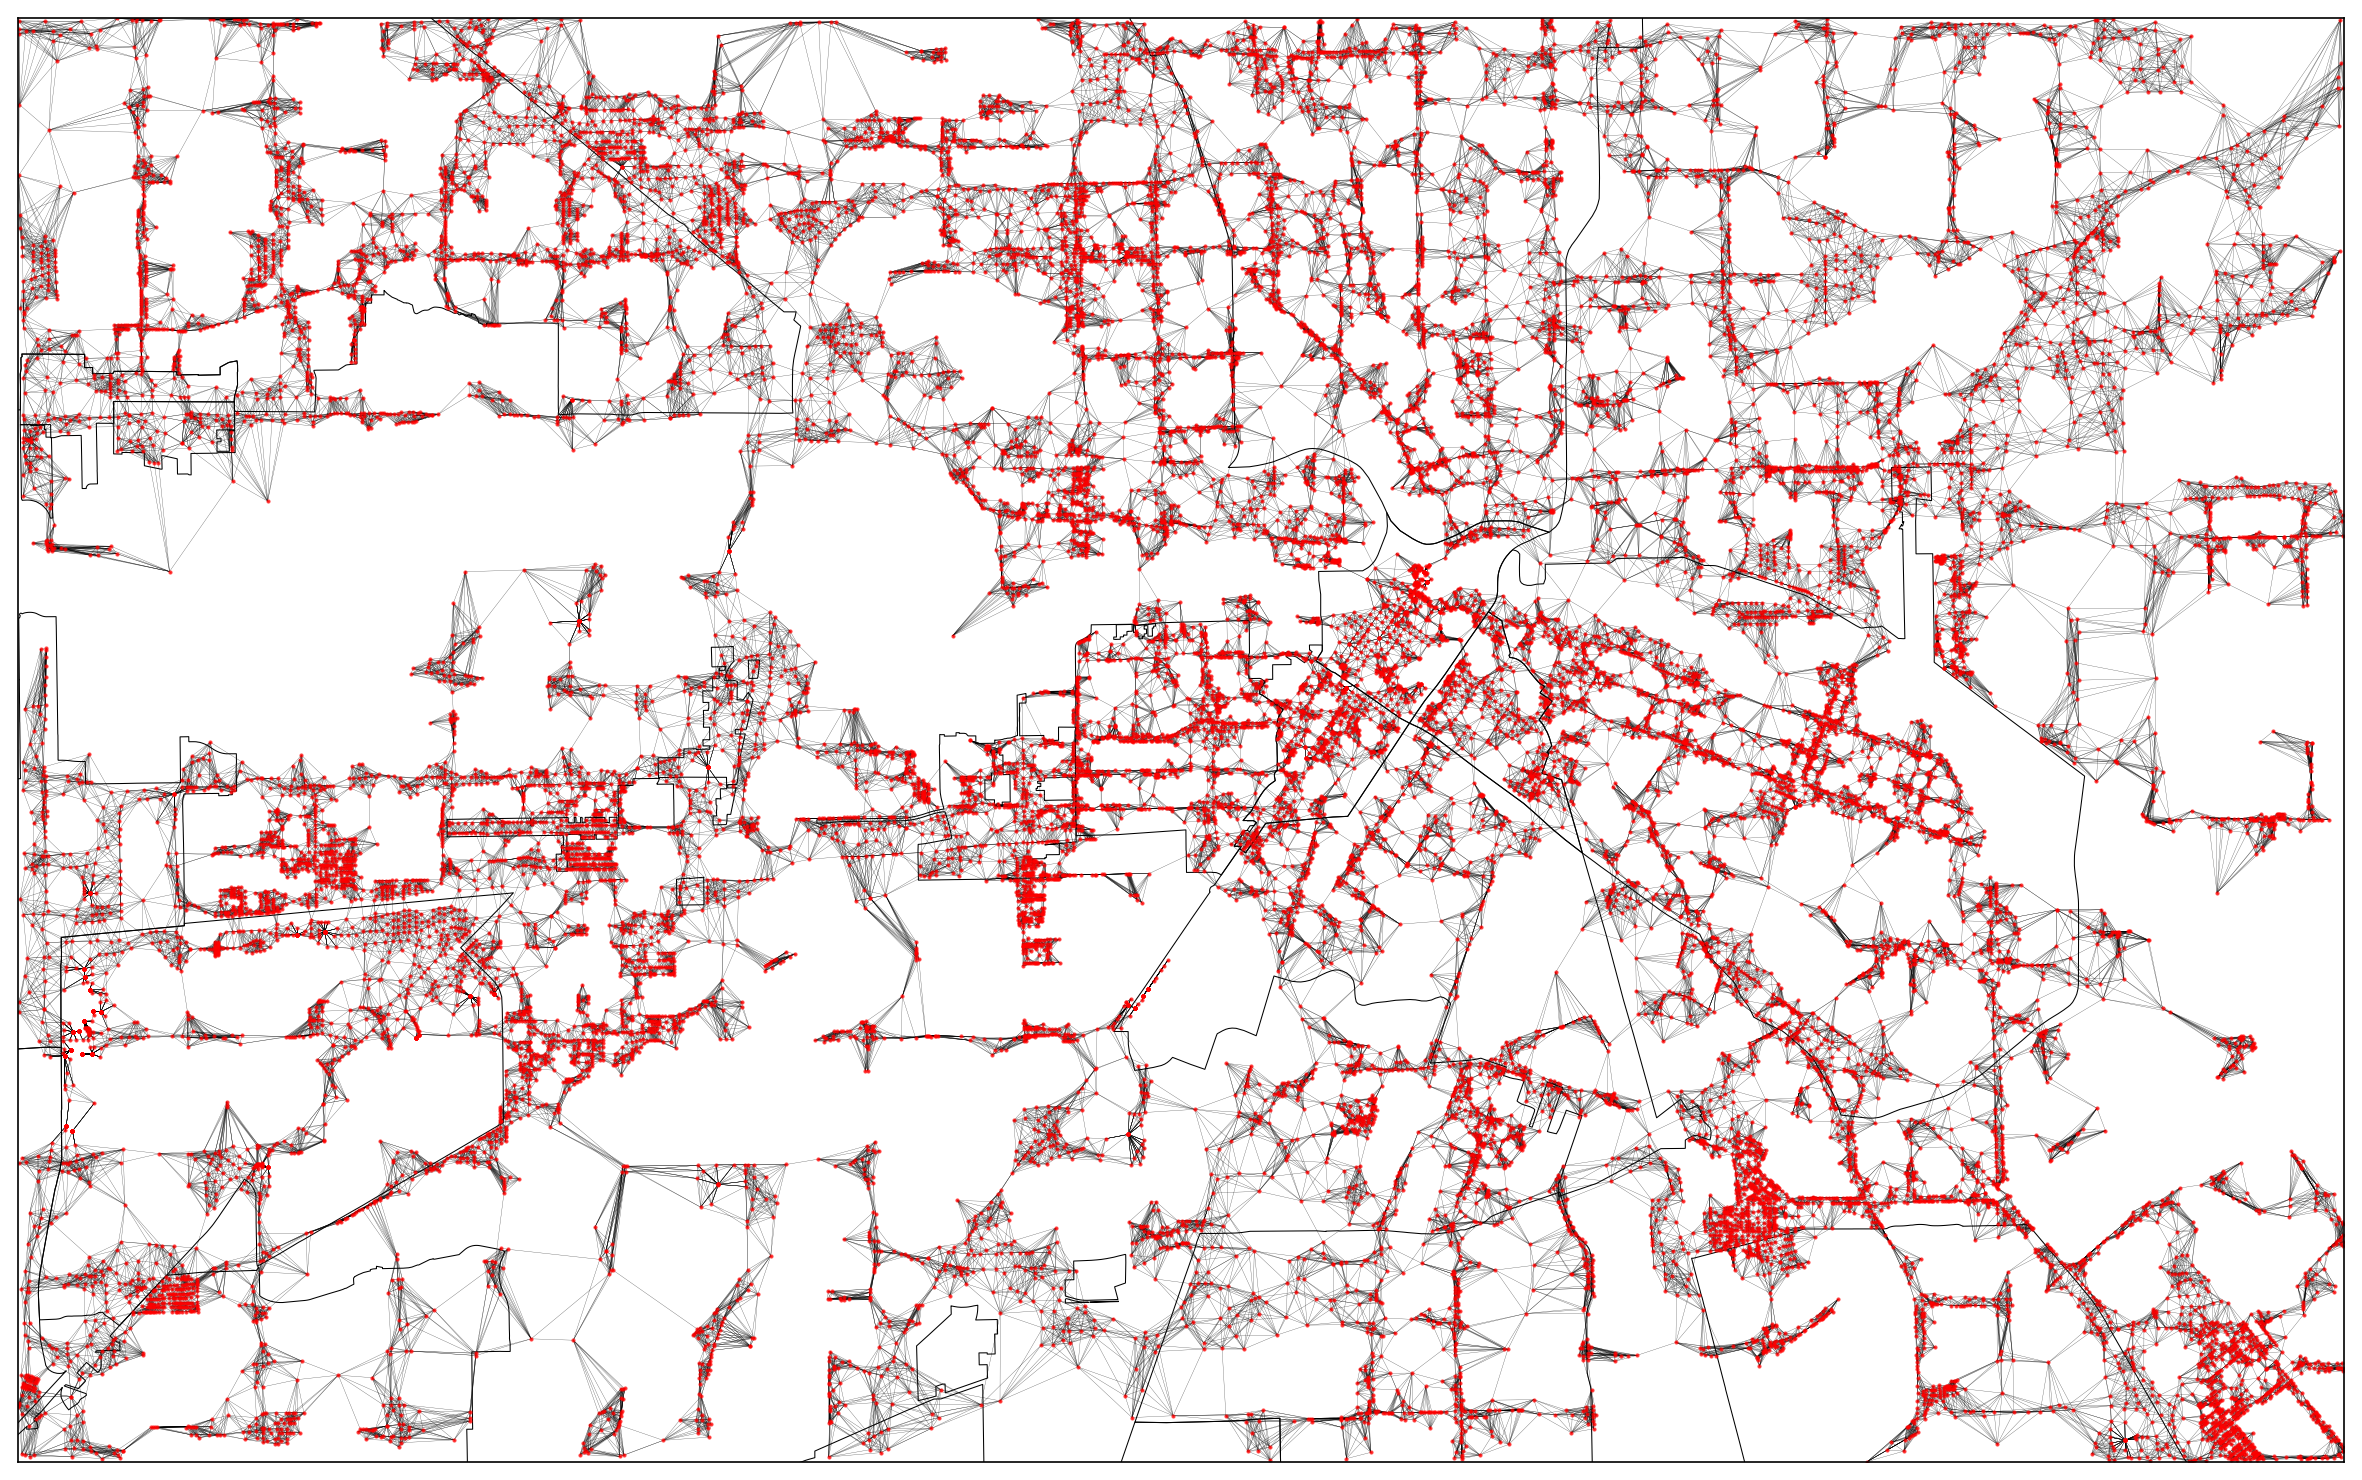

In [5]:
plt.figure(figsize=(20, 20), dpi=150)
m.readshapefile('../houston/shapefiles/Management_Districts', 'Management_Districts')
positions = {i: m(pair[1], pair[2]) 
             for i, pair in enumerate(luF1[['lon', 'lat']].itertuples())}
nx.draw_networkx(weighted_G, positions, node_size=1, with_labels=False, alpha=.7, width=.15)

## $t$ threshold

After a certain $t$ value, the number of clusters when $\tau = 0$ increases sharply

Loading eigen values/vectors from file...
done! (0.08s)
Done with time 0.001...
Done with time 0.00223872113856834...
Done with time 0.005011872336272725...
Done with time 0.01122018454301963...
Done with time 0.025118864315095794...
Done with time 0.05623413251903491...
Done with time 0.12589254117941662...
Done with time 0.2818382931264452...
Done with time 0.630957344480193...
Done with time 1.412537544622754...
Done with time 3.1622776601683795...
Done with time 7.079457843841373...
Done with time 15.84893192461111...
Done with time 35.481338923357534...
Done with time 79.43282347242805...
Done with time 177.82794100389228...
Done with time 398.1071705534969...
Done with time 891.2509381337441...
Done with time 1995.2623149688789...
Done with time 4466.835921509626...
Done with time 10000.0...
Finished in 25.30 seconds


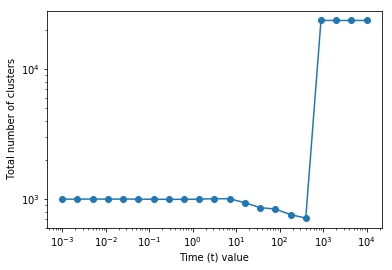

In [6]:
#ts = [1e-6, 1e-4, 1e-2, 1e0, 1e2, 1e4, 1e6, 1e8, 1e10]
ts = list(np.logspace(-3, 4, num=21))
weighted_hks_dict = {}
weighted_hks_dict = hks_s(weighted_G, ts, list(weighted_G.nodes()), verbose=True, k=1000,
                          eigen_save_loc='eigen_saves/weighted_houston_knn_norm')
def get_num_clusters(G, hks_dict, t):
    #_,PD_points = persistence_diagram(G, f=hks_dict[t])
    PD_points = {}
    C,_ = persistence_diagram(G, f=hks_dict[t], tau=0)
    return len(PD_points.keys()), len(set(get_root(node, C) for node in C))
num_clusters = []
c_set_size = []
for t in ts:
    points, cpoints = get_num_clusters(weighted_G, weighted_hks_dict, t=t)
    num_clusters.append(points)
    c_set_size.append(cpoints)
plt.figure()
#plt.plot(ts, num_clusters)
plt.plot(ts, c_set_size, 'o', linestyle='-')
plt.xlabel('Time (t) value')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Total number of clusters')
plt.show()

In [7]:
print(c_set_size)
print(ts)

[999, 999, 1000, 999, 1000, 999, 997, 995, 995, 999, 1006, 1006, 937, 860, 838, 760, 714, 23581, 23581, 23581, 23581]
[0.001, 0.00223872113856834, 0.005011872336272725, 0.01122018454301963, 0.025118864315095794, 0.05623413251903491, 0.12589254117941662, 0.2818382931264452, 0.630957344480193, 1.412537544622754, 3.1622776601683795, 7.079457843841373, 15.84893192461111, 35.481338923357534, 79.43282347242805, 177.82794100389228, 398.1071705534969, 891.2509381337441, 1995.2623149688789, 4466.835921509626, 10000.0]


Loading eigen values/vectors from file...
done! (0.08s)
Done with time 1e-299...
Done with time 1e-09...
Done with time 1.0...
Done with time 0.37...
Finished in 4.36 seconds


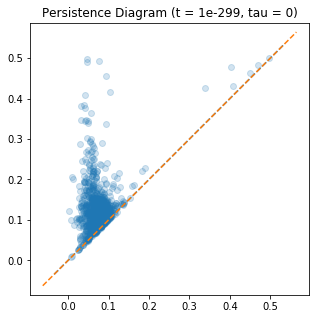

/home/ubuntu/anaconda3/envs/mainEnv/lib/python3.6/site-packages/networkx/drawing/layout.py:499: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt((delta**2).sum(axis=0))


AttributeError: 'list' object has no attribute 'shape'

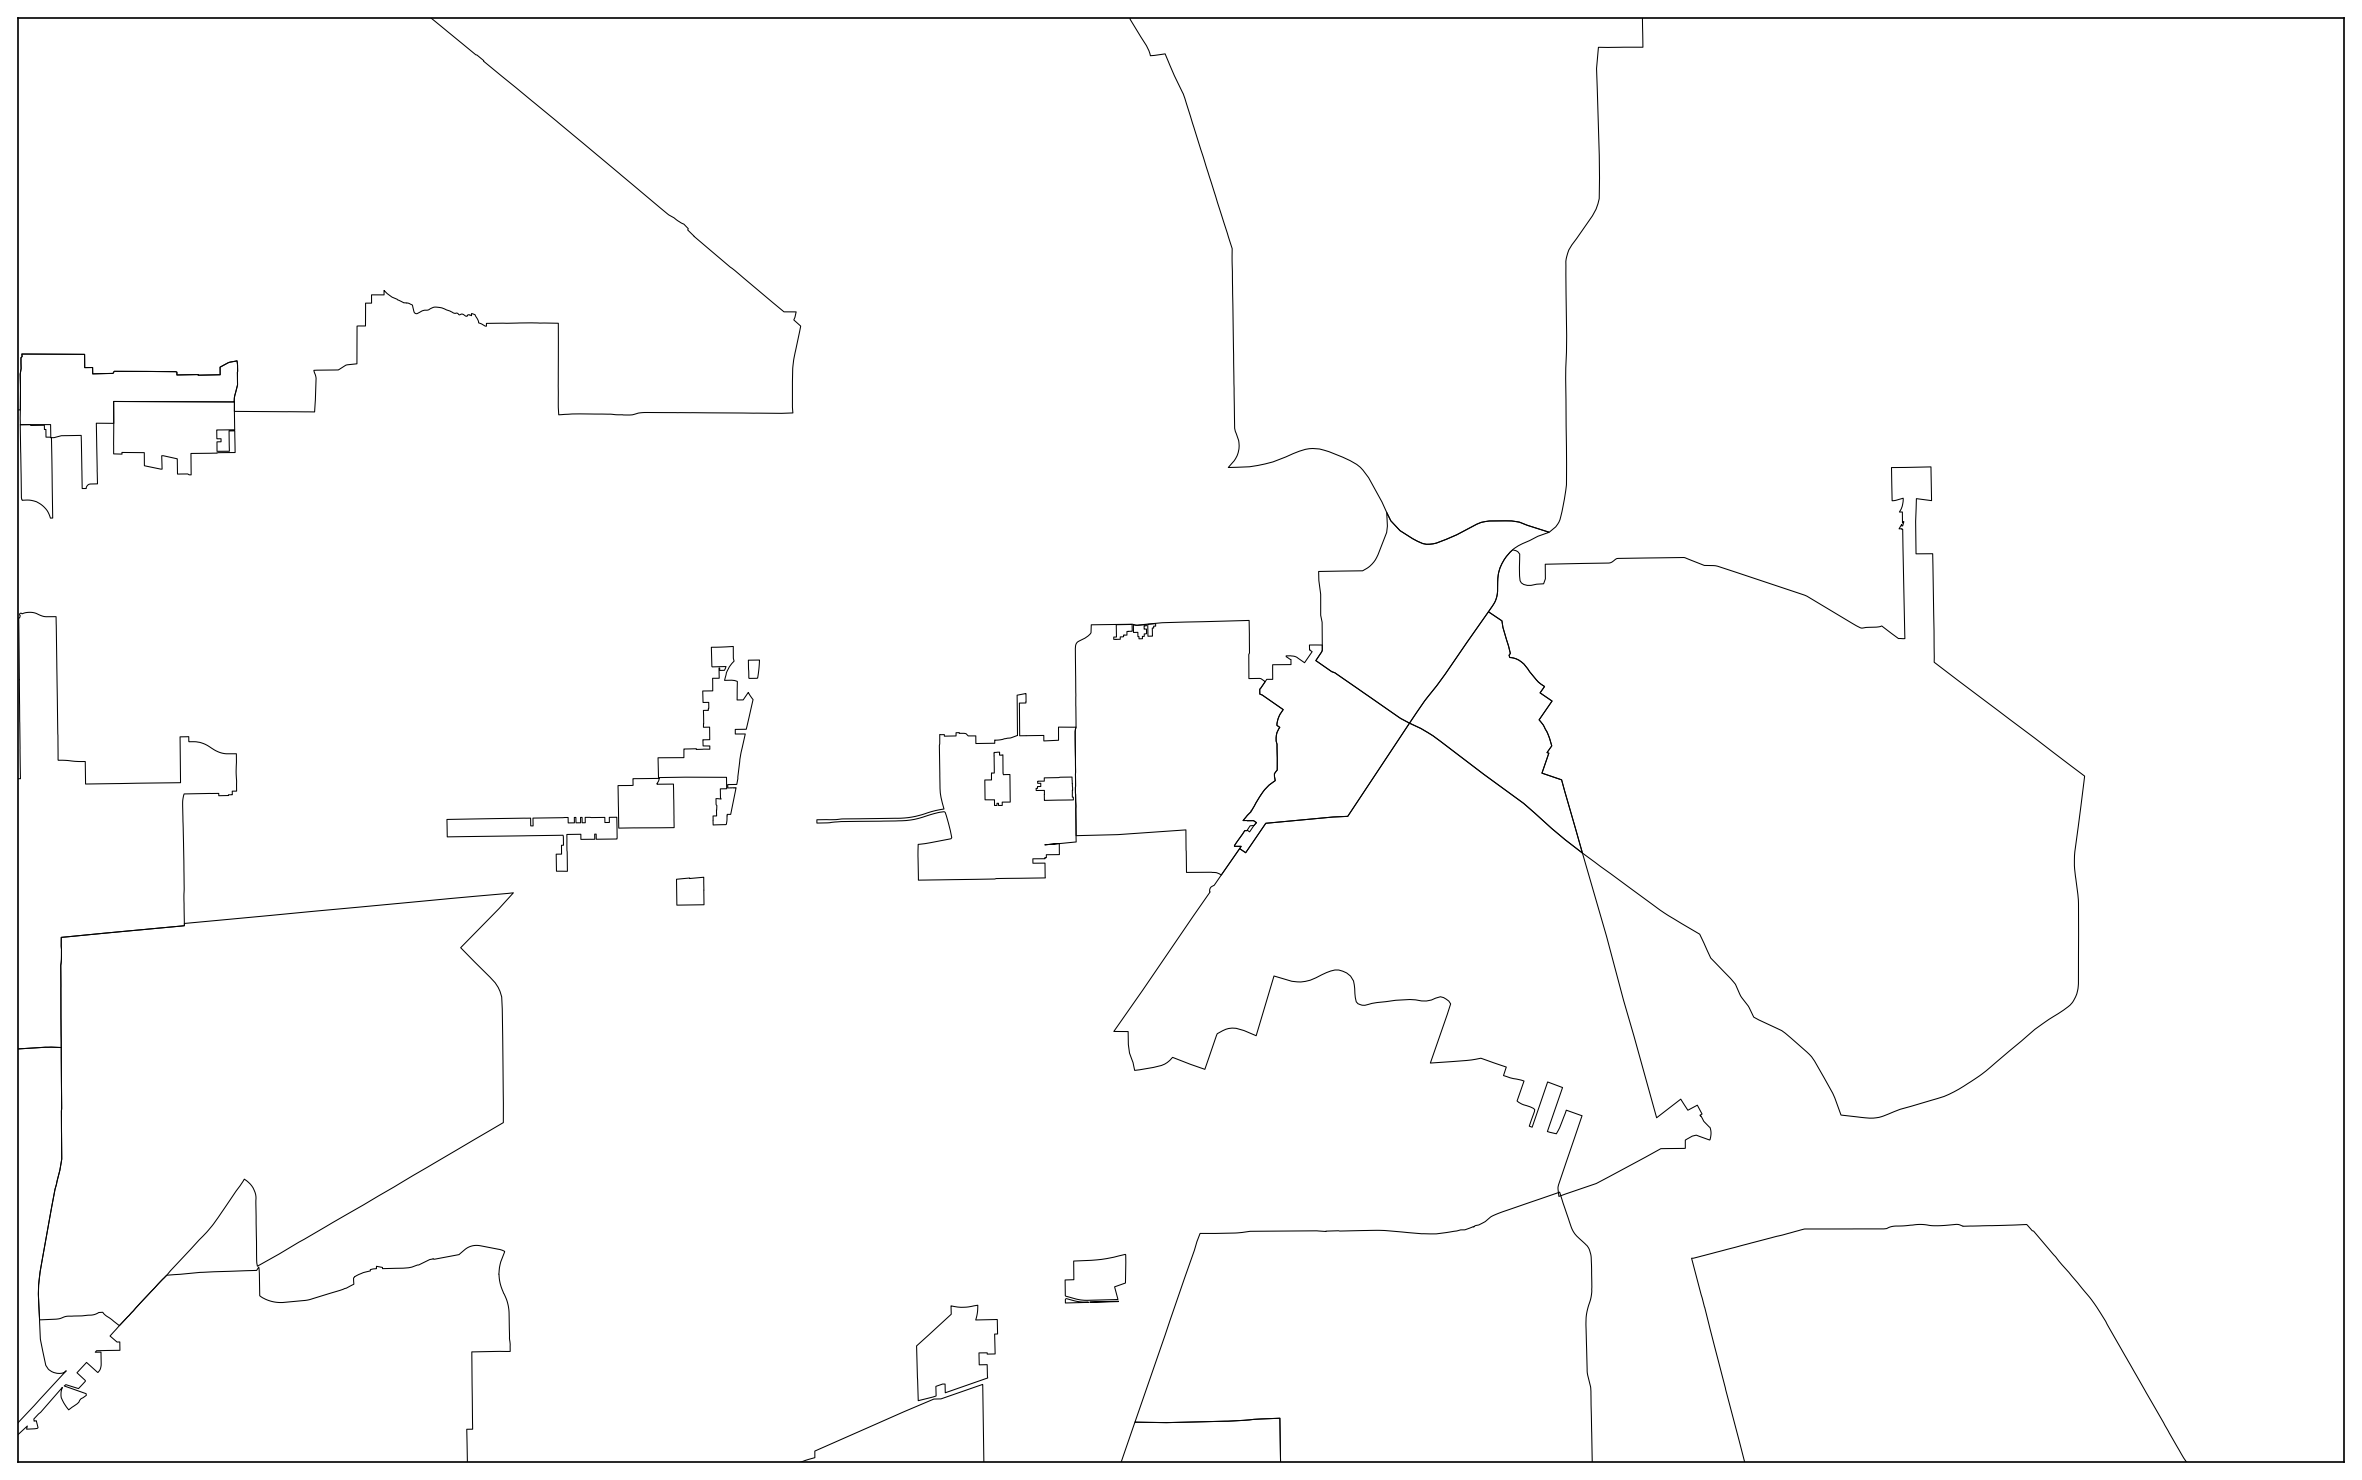

In [8]:
def explore_components(G, hks_dict, t, tau):
    _, PD_points = persistence_diagram(G, f=hks_dict[t])
    plt.figure(figsize=(5,5))
    plt.title('Persistence Diagram (t = ' + str(t) + ', tau = ' + str(tau) + ')')
    plot_PD(PD_points, tau=tau)
    plt.show()
    C, _ = persistence_diagram(G, tau=tau, f=hks_dict[t])
    plt.figure(figsize=(20, 20), dpi=150)
    m.readshapefile('../houston/shapefiles/Management_Districts', 'Management_Districts')
    plot_segments(G, C, positions, node_size=10, width=.15)
    return len(PD_points.keys())
ts = [10e-300, 10e-10, 10e-1, 0.37]
weighted_hks_dict = hks_s(weighted_G, ts, list(weighted_G.nodes()), verbose=True, k=1000,
                          eigen_save_loc='eigen_saves/weighted_houston_knn_norm')
for t in ts:
    explore_components(weighted_G, weighted_hks_dict, t, tau=0)

In [ ]:
taus = [0.01, 0.1, 0.5]
for tau in taus:
    explore_components(weighted_G, weighted_hks_dict, t=1e-9, tau=tau)

In [ ]:
def get_cluster_sizes(C):
    from collections import defaultdict
    counter = defaultdict(int)
    for node in C:
        counter[get_root(node, C)] += 1
    return counter

bwah = []
for t in ts:
    C, _ = persistence_diagram(weighted_G, tau=0, f=weighted_hks_dict[t])
    gcs = get_cluster_sizes(C)
    bwah.append(sum(gcs.values()) / len(gcs.values()))
plt.plot(ts, bwah)